In [3]:
from lxml import etree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import matplotlib.ticker as ticker

Some constants

In [4]:
N_VECTORS = 1e6
ONE_MB = 2 ** 20
FLOAT_SIZE_B = 4
VECTOR_DIM = 128
VECTOR_SIZE = VECTOR_DIM * FLOAT_SIZE_B
VECTOR_SIZE_MB = VECTOR_SIZE / ONE_MB
N_QUERY_VECTORS = 1e4
NS_PER_S = 1e9
S_PER_MIN = 60
MS_PER_S = 1e3

# `preassign_query()`: Execution time

## Parsing measurements from xml output of testing framework

In [5]:
!head -n 10 preassign_query.xml

<?xml version="1.0" encoding="UTF-8"?>
<Catch name="testmain" filters="[StorageIndex][preassign_query][benchmark]">
  <Group name="testmain">
    <TestCase name="Scenario: preassign_query()"
      tags="[StorageIndex][SIFT1M][benchmark][preassign_query]"
      filename="tests/IndexTest.cpp" line="344">
      <Section name="Given: the SIFT1M dataset" filename="tests/IndexTest.cpp" line="346">
        <Section name="Then: all required files are present" filename="tests/IndexTest.cpp"
          line="367">
          <OverallResults successes="5" failures="0" expectedFailures="0" />


In [6]:
# read `n_lists` and `n_probe` benchmark parameters which are stored in a `Warning` tag (key := value) preceding the `BenchmarkResults` tag
def extract_benchmark_params(element):
    params = {}
    for sibling in element.itersiblings(preceding=True):
        if sibling.tag == 'Warning':
            parts = list(map(lambda s: s.strip(), sibling.text.split(':=')))
            params[parts[0]] = parts[1]
    return params

def parse_xml(path):
    tree = ET.parse(path)
    root = tree.getroot()
    results = []
    for match in root.iter('BenchmarkResults'):
        result = extract_benchmark_params(match)
        result['mean'] = match.find('mean').get('value')
        result['std'] = match.find('standardDeviation').get('value')
        results.append(result)
    return results
results = parse_xml('preassign_query.xml')

In [7]:
# find StdOut tag where the benchmark also wrote the insertion time of `bulk_insert_entries` (which we haven't look at for varying n_lists n_probe so far)
def get_bulk_insert_durations(path):
    tree = ET.parse(path)
    root = tree.getroot()
    stdout = root.find('.//StdOut')
    stdout_text = stdout.text
    bulk_insert_durations = []
    for line in stdout_text.split('\n'):
        if 'took' in line:
            seconds = line.lstrip('bulk_insert_entries: took ').rstrip(' s')
            bulk_insert_durations.append(float(seconds))
    return bulk_insert_durations
bulk_insert_durations = get_bulk_insert_durations('preassign_query.xml')

In [8]:
# merge bulk_insert_durations with results
for i in range(len(results)):
  results[i]['bulk_insert_duration'] = bulk_insert_durations[i]

In [9]:
def results_to_df(results, include_bulk_insert_duration=False):
    df = pd.DataFrame(results)
    df['mean'] = df['mean'].astype(float)
    df['std'] = df['std'].astype(float)
    df['n_probe'] = df['n_probe'].astype(int)
    df['n_lists'] = df['n_lists'].astype(int)
    # convert mean and std from nanoseconds to seconds, we divide by 10^9
    # since the benchmark runs for 10^4 query vectors, we divide by another 10^4
    df['mean'] = df['mean'] / NS_PER_S / N_QUERY_VECTORS
    df['std'] = df['std'] / NS_PER_S / N_QUERY_VECTORS
    # reorder columns
    columns = ['n_lists', 'n_probe', 'mean', 'std']
    if include_bulk_insert_duration:
        columns.append('bulk_insert_duration')
    return df[columns]

centroids_df = results_to_df(results, include_bulk_insert_duration=True)
centroids_df


,n_lists,n_probe,mean,std,bulk_insert_duration
0,256,1,0.000136,1.868600e-07,1.81992
1,256,2,0.000138,2.080660e-07,1.83195
2,256,4,0.000143,1.290300e-08,1.81749
3,256,8,0.000154,9.250140e-07,1.80262
4,256,16,0.000168,2.341830e-07,1.87537
5,256,32,0.000198,1.106460e-07,1.87103
6,256,64,0.000242,1.428050e-07,1.87679
7,256,128,0.000300,2.997410e-08,1.80231
8,512,1,0.000270,4.225020e-08,2.07676
9,512,2,0.000273,1.677190e-07,2.00754


## Search space size for the vector search and centroids search
- Since we normalized the measurements by dividing by the number of query vectors, here we consider the search space size and the size of the candidates for a single query vector as well.
- Since we're searching through the SIFT1M dataset with $10^6$ vectors, we can compute the number of vectors per list `n_vectors_per_list` given the number of lists `n_lists`:
$$
\text{n\_vectors\_per\_list} = \frac{10^6}{\text{n\_lists}}
$$.
- We find the total number of vectors which need to be searched as the product of `n_vectors_per_list` and `n_probe`, therefore:

$$
\text{n\_vectors\_to\_search} = \text{n\_vectors\_per\_list} * \text{n\_probe} = \frac{10^6}{\text{n\_lists}} * \text{n\_probe}
$$.

- Assuming $128$-dimensional vectors of floats, we can estimate the size of the search space in MB as:
$$
\text{vector\_size\_mb} = \frac{128 * 4}{2^{20}}
$$
$$
\text{search\_space\_size\_mb} = \text{n\_vectors\_to\_search} * \text{vector\_size\_mb}
$$.

- For `preassign_query`, the search space is only proportional to the number of lists since we only need to compare against one centroid per list. Therefore, we can compute the search space size as:
$$
\text{centroids\_total\_size\_mb} = \text{n\_lists} * \text{vector\_size\_mb}
$$.

In [10]:
def add_space_estimates(df):
  df['n_vectors_to_search'] = N_VECTORS / df['n_lists'] * df['n_probe']
  df['search_space_size_mb'] = (df['n_vectors_to_search'] * VECTOR_SIZE_MB).round(1)
  df['centroids_total_size_mb'] = (df['n_lists'] * VECTOR_SIZE_MB).round(1)

In [11]:
marker_cycler = cycler(color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
                         '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
                         '#bcbd22', '#17becf'], marker=['o', 's', '^', 'd', '*', '+', 'x', 'v', 'p', 'h'])

In [12]:
def plot(df, y_col, ylabel, title, yerr_col=None, legend_loc='best', yformatter=ticker.ScalarFormatter(), yaxis_log=False, plot_over_lists=False):
    if plot_over_lists:
        x_col = 'n_lists'
        series_col = 'n_probe'
        x_label = 'Number of lists'
        legend_title = 'Number of probes'
    else:
        x_col = 'n_probe'
        series_col = 'n_lists'
        x_label = 'Number of probes'
        legend_title = 'Number of lists'
    fig, ax = plt.subplots(tight_layout=True)
    ax.set_prop_cycle(marker_cycler)
    ax.set_title(title)
    for n_lists in reversed(sorted(df[series_col].unique())):
        params = {'markersize': 7, 'lw': 2, 'label': f'{n_lists}'}
        df_subset = df[df[series_col] == n_lists]
        if yerr_col:
            params = {**params, 'capsize': 7, 'capthick': 1}
            ax.errorbar(x=df_subset[x_col], y=df_subset[y_col], yerr=df_subset[yerr_col], **params)
        else:    
            ax.plot(df_subset[x_col], df_subset[y_col], **params)

    ax.set_xlabel(x_label)
    ax.set_xscale('log')
    ax.xaxis.set_major_locator(ticker.LogLocator(base=2))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(ticker.NullLocator())

    if yaxis_log:
        ax.set_yscale('log')
    ax.set_ylabel(ylabel)
    ax.yaxis.set_major_formatter(yformatter)

    ax.legend(title=legend_title, loc=legend_loc)
    plt.show()

s_to_ms_formatter = ticker.FuncFormatter(lambda x, pos: '{:0.0f}'.format(x*1000))

Here, we see how the search space behaves as we increase the number of lists and probes.
- The search space for the centroids search, i.e. `preassign_query`, grows linearly but only in proportion to the number of lists.


In [13]:
add_space_estimates(centroids_df)
centroids_mean_by_n_lists_df = centroids_df.groupby('n_lists').mean()
centroids_std_by_n_lists_df = centroids_df.groupby('n_lists').std()
centroids_mean_by_n_lists_df

,n_probe,mean,std,bulk_insert_duration,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb
n_lists,,,,,,,
256,31.875,0.000185,2.313064e-07,1.837185,124511.718750,60.7875,0.1
512,31.875,0.000335,2.285149e-07,2.058088,62255.859375,30.4000,0.2
1024,31.875,0.000618,3.696054e-07,62.315562,31127.929688,15.2000,0.5
2048,31.875,0.001170,2.462103e-07,84.705475,15563.964844,7.6000,1.0
4096,31.875,0.002254,2.880839e-07,106.122362,7781.982422,3.8000,2.0


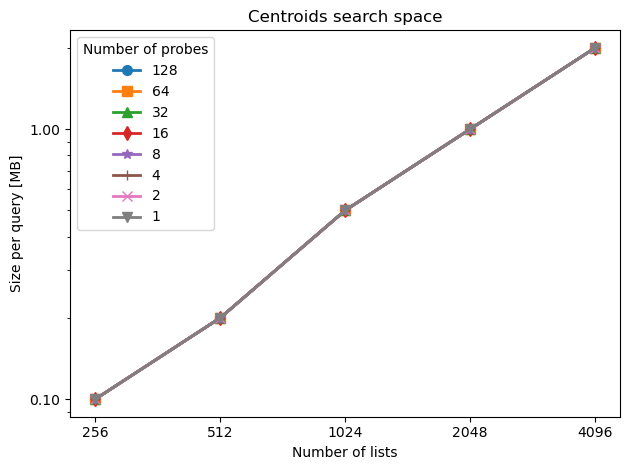

In [14]:
plot(centroids_df, 'centroids_total_size_mb', 'Size per query [MB]', 'Centroids search space', plot_over_lists=True, yaxis_log=True)

In [15]:
centroids_mean_by_n_probe_df = centroids_df.groupby('n_probe').mean()
centroids_std_by_n_probe_df = centroids_df.groupby('n_probe').std()
centroids_mean_by_n_probe_df

,n_lists,mean,std,bulk_insert_duration,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb
n_probe,,,,,,,
1,1587.2,0.000831,2.461928e-07,46.241436,1513.671875,0.74,0.76
2,1587.2,0.000835,4.375856e-07,54.558678,3027.343750,1.48,0.76
4,1587.2,0.000841,8.546926e-08,49.060300,6054.687500,2.96,0.76
8,1587.2,0.000854,5.057478e-07,53.358358,12109.375000,5.92,0.76
16,1587.2,0.000876,3.137668e-07,48.372212,24218.750000,11.82,0.76
32,1587.2,0.000922,1.785028e-07,53.458952,48437.500000,23.64,0.76
64,1587.2,0.001002,2.997753e-07,52.726932,96875.000000,47.30,0.76
128,1587.2,0.001137,1.149130e-07,53.485008,193750.000000,94.60,0.76


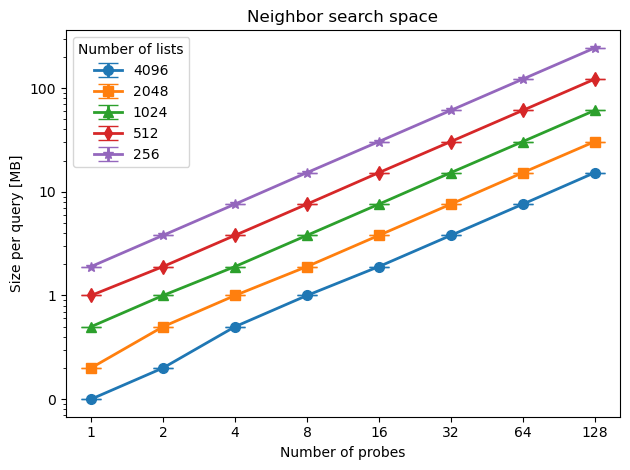

In [16]:
plot(centroids_df, 'search_space_size_mb', 'Size per query [MB]', 'Neighbor search space', yerr_col='std', plot_over_lists=False, yaxis_log=True)

## Visualizing execution time

### Results of `preassign_query()`
- As we can see in the below loglog plot, `preassign_query` scales linearly with the number of lists.

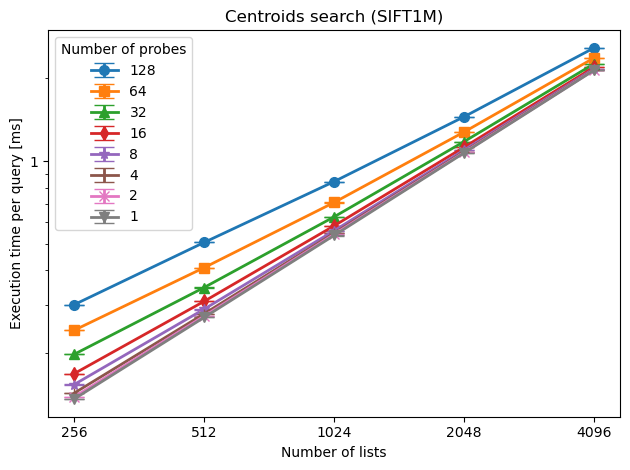

In [17]:
plot(df=centroids_df, y_col='mean', yerr_col='std', ylabel='Execution time per query [ms]', title='Centroids search (SIFT1M)', legend_loc='upper left', plot_over_lists=True, yaxis_log=True, yformatter=s_to_ms_formatter)

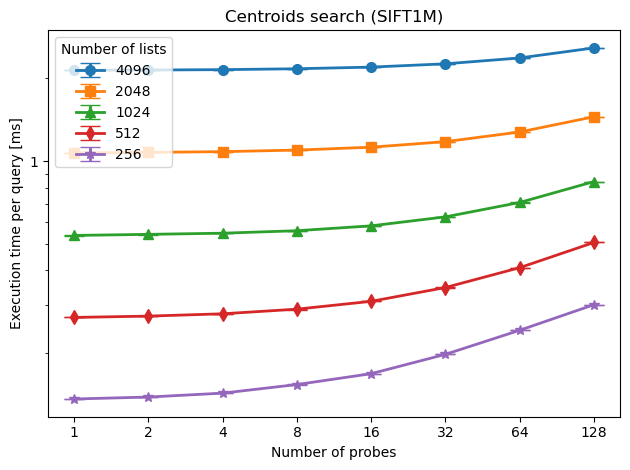

In [18]:
plot(df=centroids_df, y_col='mean', yerr_col='std', ylabel='Execution time per query [ms]', title='Centroids search (SIFT1M)', legend_loc='upper left', plot_over_lists=False, yaxis_log=True, yformatter=s_to_ms_formatter)

## Throughput of `preassign_query()`

In [19]:
def get_vector_throughput(df, n_vectors_column, seconds_column):
    vectors_per_s = (df[n_vectors_column] / df[seconds_column]).round(1)
    mb_per_s = (vectors_per_s * VECTOR_SIZE / ONE_MB).round(1)
    return vectors_per_s, mb_per_s

def add_centroids_search_throughput(centroids_df):
    centroids_df['vectors_per_s'], centroids_df['mb_per_s'] = get_vector_throughput(centroids_df, 'n_lists', 'mean')
    return centroids_df

add_centroids_search_throughput(centroids_df)
centroids_df

,n_lists,n_probe,mean,std,bulk_insert_duration,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,vectors_per_s,mb_per_s
0,256,1,0.000136,1.868600e-07,1.81992,3906.250000,1.9,0.1,1880748.8,918.3
1,256,2,0.000138,2.080660e-07,1.83195,7812.500000,3.8,0.1,1850312.6,903.5
2,256,4,0.000143,1.290300e-08,1.81749,15625.000000,7.6,0.1,1790660.6,874.3
3,256,8,0.000154,9.250140e-07,1.80262,31250.000000,15.3,0.1,1666015.9,813.5
4,256,16,0.000168,2.341830e-07,1.87537,62500.000000,30.5,0.1,1520903.5,742.6
5,256,32,0.000198,1.106460e-07,1.87103,125000.000000,61.0,0.1,1293203.6,631.4
6,256,64,0.000242,1.428050e-07,1.87679,250000.000000,122.1,0.1,1056934.1,516.1
7,256,128,0.000300,2.997410e-08,1.80231,500000.000000,244.1,0.1,852844.4,416.4
8,512,1,0.000270,4.225020e-08,2.07676,1953.125000,1.0,0.2,1898243.8,926.9
9,512,2,0.000273,1.677190e-07,2.00754,3906.250000,1.9,0.2,1877314.6,916.7


## Plotting the throughput of `preassign_query()`
- Search space = number of centroids to compare against = `n_lists`
- Candidates = number of closest centroids to find = `n_probe`
- For a fixed `n_lists` and increasing `n_probe`, we expect the throughput to decrease since we need to compare against the current list of `n_probe` candidates (using a heap) while searching through the constant search space which is fixed with the number of lists.

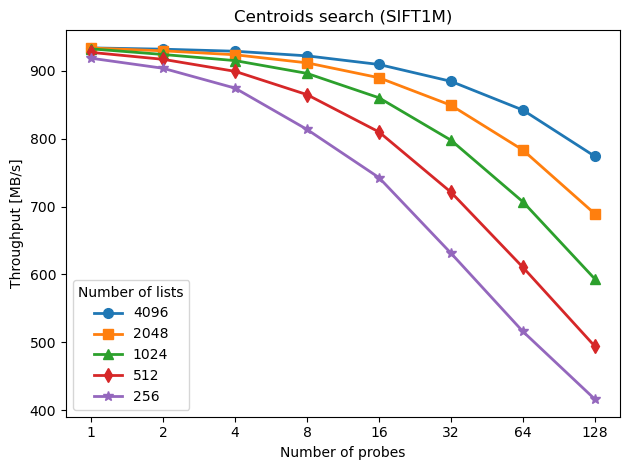

In [20]:
plot(df=centroids_df, y_col='mb_per_s', ylabel='Throughput [MB/s]', title='Centroids search (SIFT1M)')

# `bulk_insert_entries`: Execution time
- In the following loglog plot, we see the insertion time scales linearly with varying `n_lists` which we haven't look at so far.
- `n_probe` doesn't affect the execution time of `bulk_insert_entries` as we would expect.
- From $512$ to $1024$ lists, we notice a jump in execution time of about two orders of magnitude. Since the average search space decreases and the average size of the candidates set is constant, we can conclude that the jump is likely caused by a more spread out distribution of active write locations due to the large `n_lists`. The cache might not be able to keep all tails of the lists and has to fetch them from main memory more often.

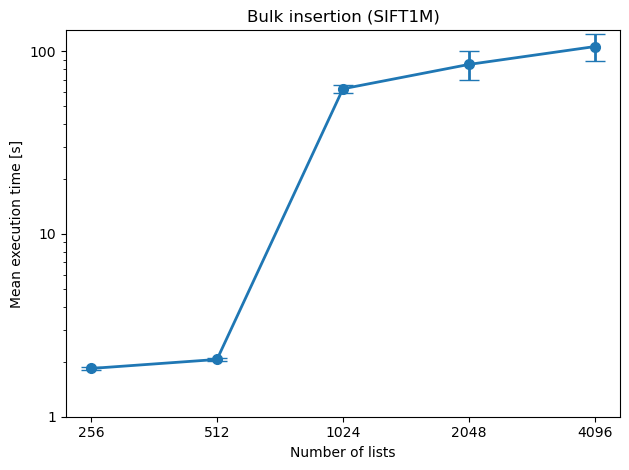

In [21]:
fig, ax = plt.subplots(tight_layout=True)
ax.set_prop_cycle(marker_cycler)
ax.set_title('Bulk insertion (SIFT1M)')
# for n_probe in sorted(filtered_df['n_probe'].unique()):
#     df_subset = filtered_df[filtered_df['n_probe'] == n_probe]
#     ax.plot(df_subset['n_lists'], df_subset['bulk_insert_duration'], label=f'{n_probe}', markersize=6, lw=2)
ax.errorbar(centroids_mean_by_n_lists_df.index, centroids_mean_by_n_lists_df['bulk_insert_duration'], label='Mean execution time', markersize=7, lw=2, yerr=centroids_std_by_n_lists_df['bulk_insert_duration'], capsize=7)

ax.set_ylim(bottom=1)

ax.set_xlabel('Number of lists') 
ax.set_xscale("log")
ax.xaxis.set_major_locator(ticker.LogLocator(base=2))
ax.xaxis.set_minor_locator(ticker.NullLocator())
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False))

ax.set_ylabel('Mean execution time [s]')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False))

# ax.legend(title='Number of probes', loc='upper left')
plt.show()

# `search_preassigned`: Execution time

## Parsing measurements from log file
- Note that the execution time measured includes the time to find the nearest centroids, which we will exclude in a following step.

In [22]:
!head -n 10 search_preassigned.log


Filters: [StorageIndex][search_preassigned][benchmark]
Inserted 1000000 entries of 1000000 (100%)
bulk_insert_entries: took 1.80958 s
search_preassigned() with n_lists=256 and n_probe=1

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
testmain is a Catch v2.13.10 host application.
Run with -? for options



In [23]:
!tail -n 15 search_preassigned.log

tests/IndexTest.cpp:314
...............................................................................

benchmark name                       samples       iterations    estimated
                                     mean          low mean      high mean
                                     std dev       low std dev   high std dev
-------------------------------------------------------------------------------
search_preassigned(): includes                                                 
finding the nearest centroids                    3             1     9.64633 m 
                                         3.21314 m     3.21289 m     3.21328 m 
                                        10.9139 ms          0 ns    11.9666 ms 
                                                                               

All tests passed (320 assertions in 1 test case)


- In the console output, the duration is given in either minutes, seconds or milliseconds. We need to convert it to seconds.
- Since the benchmark runs for N_QUERY_VECTORS queries, we need to divide the duration by N_QUERY_VECTORS

In [24]:
results = []
parse_next_lines = 0
with open('search_preassigned.log', 'r') as f:
  for line in f:
    if 'bulk_insert_entries: took ' in line:
      seconds = line.lstrip('bulk_insert_entries: took ')
      seconds = seconds.rstrip(' s\n')
      results.append({'bulk_insert_duration': float(seconds)})
    elif 'search_preassigned() with n_lists=' in line:
      n_lists = line.split('n_lists=')[1].split(' ')[0]
      n_probe = line.split('n_probe=')[1].split(' ')[0]
      results[-1]['n_lists'] = int(n_lists)
      results[-1]['n_probe'] = int(n_probe)
    elif 'finding the nearest centroids ' in line:
      parse_next_lines = 2
    elif parse_next_lines == 2:
      parts = line.lstrip().split(' ')
      mean = float(parts[0])
      if parts[1] == 'm':
        mean *= S_PER_MIN
      results[-1]['mean'] = mean / N_QUERY_VECTORS
      parse_next_lines -= 1
    elif parse_next_lines == 1:
      parts = line.lstrip().split(' ')
      std = float(parts[0])
      assert parts[1] == 'ms'
      std /= MS_PER_S
      results[-1]['std'] = float(std) / N_QUERY_VECTORS
      parse_next_lines -= 1

Here, we convert the results array to a pandas dataframe for easier plotting.

In [25]:
search_to_correct_df = pd.DataFrame(results)
search_to_correct_df['mean'] = search_to_correct_df['mean'].astype(float)
search_to_correct_df['std'] = search_to_correct_df['std'].astype(float)
search_to_correct_df['n_probe'] = search_to_correct_df['n_probe'].astype(int)
search_to_correct_df['n_lists'] = search_to_correct_df['n_lists'].astype(int)
search_to_correct_df = search_to_correct_df[['n_lists', 'n_probe', 'mean', 'std', 'bulk_insert_duration']]
print(np.sqrt(pow(0.070223, 2) + pow(0.001869, 2)))
add_space_estimates(search_to_correct_df)
search_to_correct_df

0.0702478675121174


,n_lists,n_probe,mean,std,bulk_insert_duration,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb
0,256,1,0.002343,7.022260e-06,1.80958,3906.250000,1.9,0.1
1,256,2,0.004497,1.338800e-05,1.76407,7812.500000,3.8,0.1
2,256,4,0.008704,2.770320e-06,1.75547,15625.000000,7.6,0.1
3,256,8,0.016991,2.945250e-06,1.83086,31250.000000,15.3,0.1
4,256,16,0.033284,1.348380e-05,1.75532,62500.000000,30.5,0.1
5,256,32,0.065359,2.702180e-06,1.77186,125000.000000,61.0,0.1
6,256,64,0.128659,2.592080e-05,1.76177,250000.000000,122.1,0.1
7,256,128,0.255724,3.217530e-05,1.76634,500000.000000,244.1,0.1
8,512,1,0.001415,8.200250e-06,2.21337,1953.125000,1.0,0.2
9,512,2,0.002505,5.549080e-06,2.09262,3906.250000,1.9,0.2


In [26]:
centroids_df

,n_lists,n_probe,mean,std,bulk_insert_duration,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,vectors_per_s,mb_per_s
0,256,1,0.000136,1.868600e-07,1.81992,3906.250000,1.9,0.1,1880748.8,918.3
1,256,2,0.000138,2.080660e-07,1.83195,7812.500000,3.8,0.1,1850312.6,903.5
2,256,4,0.000143,1.290300e-08,1.81749,15625.000000,7.6,0.1,1790660.6,874.3
3,256,8,0.000154,9.250140e-07,1.80262,31250.000000,15.3,0.1,1666015.9,813.5
4,256,16,0.000168,2.341830e-07,1.87537,62500.000000,30.5,0.1,1520903.5,742.6
5,256,32,0.000198,1.106460e-07,1.87103,125000.000000,61.0,0.1,1293203.6,631.4
6,256,64,0.000242,1.428050e-07,1.87679,250000.000000,122.1,0.1,1056934.1,516.1
7,256,128,0.000300,2.997410e-08,1.80231,500000.000000,244.1,0.1,852844.4,416.4
8,512,1,0.000270,4.225020e-08,2.07676,1953.125000,1.0,0.2,1898243.8,926.9
9,512,2,0.000273,1.677190e-07,2.00754,3906.250000,1.9,0.2,1877314.6,916.7


### Correcting the estimated execution time of `search_preassigned`

In the first benchmark, the measurement of `search_preassigned` includes both the execution time of the function itself as well as the required preprocessing step `preassign_query`. In the following, we will correct the execution time of `search_preassigned` using the estimated execution time of the preprocessing step `preassign_query` of the second benchmark.

Let $S$, $C$ be normally distributed i.d.d. random variables for the actual execution times of `search_preassigned` and `preassign_query`, respectively. Then, the measured execution time $X$ of `search_preassigned` can be written as $X=C+S$ with $C$ and $S$ independent. We estimate the actual execution time of `search_preassigned` by subtracting the estimated execution time of `preassign_query` from the measured execution time of `search_preassigned`.

$$
E[S] = E[X - C] = E[X] - E[C] =: \mu
$$
$$
Var[S] = Var[X - C] = Var[X] + Var[C] =: \sigma^2
\implies \sigma = \sqrt{\sigma_X^2 + \sigma_C^2}
$$

In [27]:
def get_corrected_search_df(search_to_correct_df, centroids_df):
  search_df = search_to_correct_df.copy()
  search_df['mean'] = search_df['mean'] - centroids_df['mean']
  search_df['std'] = np.sqrt(search_df['std']**2 + search_df['std']**2)
  return search_df
search_df = get_corrected_search_df(search_to_correct_df, centroids_df)
search_df

,n_lists,n_probe,mean,std,bulk_insert_duration,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb
0,256,1,0.002207,0.000010,1.80958,3906.250000,1.9,0.1
1,256,2,0.004359,0.000019,1.76407,7812.500000,3.8,0.1
2,256,4,0.008561,0.000004,1.75547,15625.000000,7.6,0.1
3,256,8,0.016838,0.000004,1.83086,31250.000000,15.3,0.1
4,256,16,0.033115,0.000019,1.75532,62500.000000,30.5,0.1
5,256,32,0.065161,0.000004,1.77186,125000.000000,61.0,0.1
6,256,64,0.128417,0.000037,1.76177,250000.000000,122.1,0.1
7,256,128,0.255423,0.000046,1.76634,500000.000000,244.1,0.1
8,512,1,0.001146,0.000012,2.21337,1953.125000,1.0,0.2
9,512,2,0.002232,0.000008,2.09262,3906.250000,1.9,0.2


-

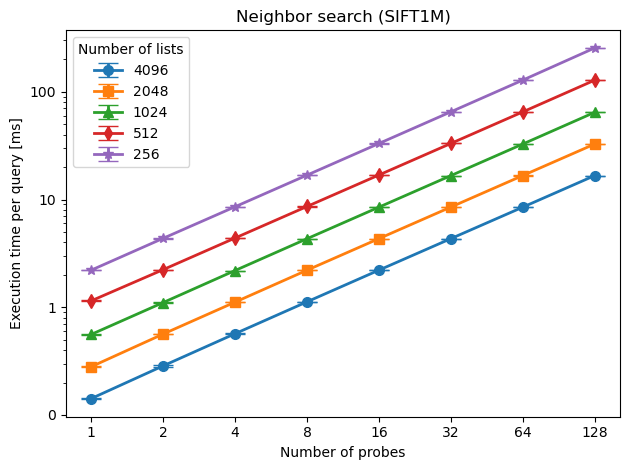

In [28]:
plot(df=search_df, y_col='mean', yerr_col='std', title='Neighbor search (SIFT1M)', ylabel='Execution time per query [ms]', yaxis_log=True, yformatter=s_to_ms_formatter)

Computing search throughput

In [29]:
def add_search_throughput(search_df):
  search_df['n_vectors_per_s'], search_df['mb_per_s'] = get_vector_throughput(search_df, 'n_vectors_to_search', 'mean')
  return search_df

add_search_throughput(search_df)
search_df


,n_lists,n_probe,mean,std,bulk_insert_duration,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,n_vectors_per_s,mb_per_s
0,256,1,0.002207,0.000010,1.80958,3906.250000,1.9,0.1,1769636.7,864.1
1,256,2,0.004359,0.000019,1.76407,7812.500000,3.8,0.1,1792406.6,875.2
2,256,4,0.008561,0.000004,1.75547,15625.000000,7.6,0.1,1825035.8,891.1
3,256,8,0.016838,0.000004,1.83086,31250.000000,15.3,0.1,1855943.2,906.2
4,256,16,0.033115,0.000019,1.75532,62500.000000,30.5,0.1,1887338.3,921.6
5,256,32,0.065161,0.000004,1.77186,125000.000000,61.0,0.1,1918318.3,936.7
6,256,64,0.128417,0.000037,1.76177,250000.000000,122.1,0.1,1946782.9,950.6
7,256,128,0.255423,0.000046,1.76634,500000.000000,244.1,0.1,1957533.8,955.8
8,512,1,0.001146,0.000012,2.21337,1953.125000,1.0,0.2,1704941.7,832.5
9,512,2,0.002232,0.000008,2.09262,3906.250000,1.9,0.2,1750253.2,854.6


Plotting the throughput of `search_preassigned()`
- Search space ~ 1 / number of lists * number of vectors per list = 1 / `n_lists` * `n_vectors_per_list`
- For a fixed `n_lists` and increasing `n_probe`, the throughput increases since we increase the search space size which reduces the relative overhead of the search.
- For a fixed `n_probe` and increasing `n_lists`, the throughput decreases since the length of the individual lists is smaller which reduces the search space size and could lead to more overhead.


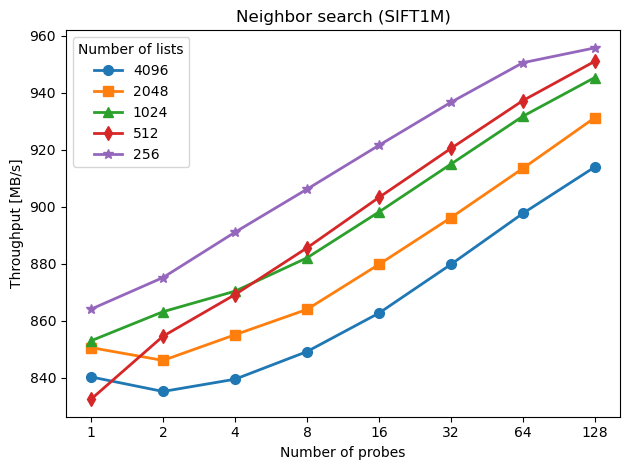

In [30]:
plot(df=search_df, y_col='mb_per_s', title='Neighbor search (SIFT1M)', ylabel='Throughput [MB/s]')

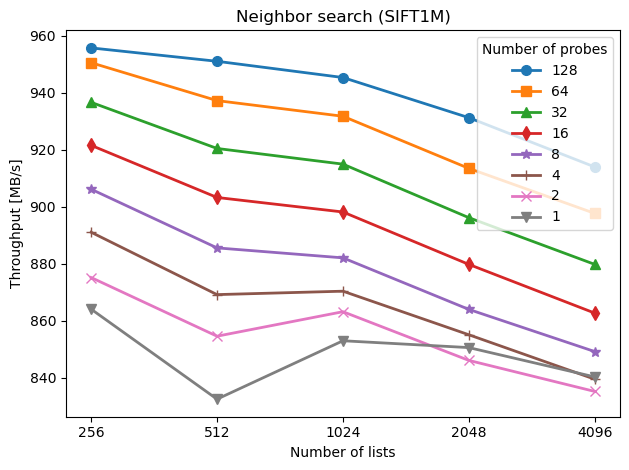

In [31]:
yformatter = ticker.FuncFormatter(lambda x, pos: '{:0.0f}'.format(x*1000))
plot(df=search_df, y_col='mb_per_s', title='Neighbor search (SIFT1M)', ylabel='Throughput [MB/s]', plot_over_lists=True)

### Example to verify the correctness of the throughput computation:
Let's take a sample measurement for `n_probe=128` and `n_lists=4096`:
- According to the raw measurent data in the log file of the benchmarks, the `search_preassigned` took $3.21314$ min $\approx 193$ s for `K=1` and $10^4$ query vectors.
- For the same parameters, the estimated execution time of `preassign_query` was $2.58428*10^{10}$ ns $\approx 26$ s.
- We compute the corrected execution time of `search_preassigned` as the difference of the means: $193 - 26 = 167$ s.
- We compute the size of the search space (i.e. total size of the number of vectors to compare against) by multiplying the number of probes with the number of vectors per list (we assume that the vectors are uniformly distributed among the lists):
$$
\text{n\_vectors\_per\_list} = \frac{10^6}{\text{n\_lists}} = \frac{10^6}{4096} \approx 244
$$
$$
\text{n\_vectors\_to\_search} = \text{n\_vectors\_per\_list} * \text{n\_probe} = 244 * 128 = 31232
$$.
- Assuming $128$-dimensional vectors of floats, we can estimate the size of the search space for a single query in MB as:
$$
\text{search\_space\_size\_single\_query\_mb} = \text{n\_vectors\_to\_search} * \frac{128 * 4}{2^{20}} = 31232 * \frac{128 * 4}{2^{20}} \approx 15
$$.
- Since we have $10^4$ query vectors, we can compute the total size of the search space in MB as:
$$
\text{search\_space\_size\_total\_mb} = \text{search\_space\_size\_single\_query\_mb} * 10^4 = 15 * 10^4 = 150000
$$.
- We can compute the throughput as:
$$
\text{throughput\_mb\_per\_s} = \frac{\text{search\_space\_size\_total\_mb}}{\text{corrected\_execution\_time\_s}} = \frac{150000}{167} \approx 900
$$.
- This result is in line with the result in the above dataframe, where the throughput for the given parameters was $913.5$ MB/s.


# SIMD

## `preassign_query()`: Execution time

Executing the benchmark by running the following command:
```bash
./out/testmain [StorageIndex][preassign_query][benchmark] --benchmark-samples 3 -r xml >> preassign_query_simd.xml
```
produces an xml file containing the measurements of the execution time of `preassign_query` for different values of `n_probe` and `n_lists`.




Reading the measurements from the xml file

In [32]:
results_simd = parse_xml('preassign_query_simd.xml')
centroids_simd_df = results_to_df(results_simd)
add_space_estimates(centroids_simd_df)
centroids_simd_df

,n_lists,n_probe,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb
0,256,1,0.000057,2.865240e-07,3906.250000,1.9,0.1
1,256,2,0.000059,2.583800e-08,7812.500000,3.8,0.1
2,256,4,0.000064,1.505830e-07,15625.000000,7.6,0.1
3,256,8,0.000083,1.100390e-07,31250.000000,15.3,0.1
4,256,16,0.000089,1.110600e-07,62500.000000,30.5,0.1
5,256,32,0.000120,9.869250e-08,125000.000000,61.0,0.1
6,256,64,0.000163,1.611240e-07,250000.000000,122.1,0.1
7,256,128,0.000220,1.681180e-07,500000.000000,244.1,0.1
8,512,1,0.000125,1.137170e-07,1953.125000,1.0,0.2
9,512,2,0.000117,1.227280e-07,3906.250000,1.9,0.2


Computing the throughput of `preassign_query()` with SIMD

In [33]:
add_centroids_search_throughput(centroids_simd_df)
centroids_simd_df

,n_lists,n_probe,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,vectors_per_s,mb_per_s
0,256,1,0.000057,2.865240e-07,3906.250000,1.9,0.1,4491180.8,2193.0
1,256,2,0.000059,2.583800e-08,7812.500000,3.8,0.1,4322754.4,2110.7
2,256,4,0.000064,1.505830e-07,15625.000000,7.6,0.1,3983729.0,1945.2
3,256,8,0.000083,1.100390e-07,31250.000000,15.3,0.1,3066999.6,1497.6
4,256,16,0.000089,1.110600e-07,62500.000000,30.5,0.1,2869620.6,1401.2
5,256,32,0.000120,9.869250e-08,125000.000000,61.0,0.1,2136377.7,1043.2
6,256,64,0.000163,1.611240e-07,250000.000000,122.1,0.1,1573448.1,768.3
7,256,128,0.000220,1.681180e-07,500000.000000,244.1,0.1,1163747.4,568.2
8,512,1,0.000125,1.137170e-07,1953.125000,1.0,0.2,4104142.6,2004.0
9,512,2,0.000117,1.227280e-07,3906.250000,1.9,0.2,4357966.1,2127.9


Plotting the throughput of `preassign_query()` with SIMD

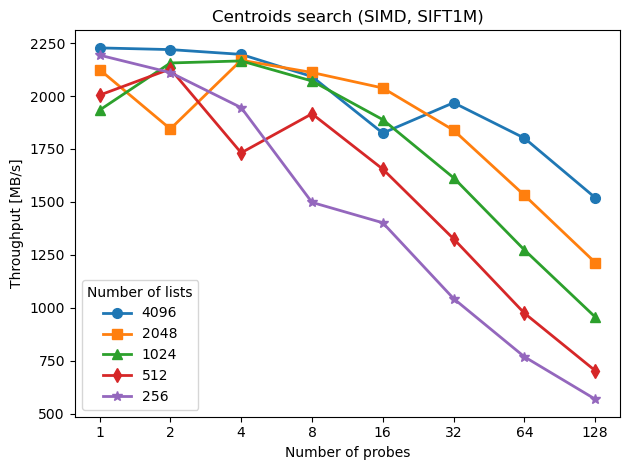

In [34]:
plot(df=centroids_simd_df, y_col='mb_per_s', title='Centroids search (SIMD, SIFT1M)', ylabel='Throughput [MB/s]')

SIMD speedup of `preassign_query()`

In [35]:
def get_speedup(old_df, new_df, column, invert=False):
  speedup = new_df[column] / old_df[column]
  if invert:
    speedup = 1 / speedup
  return speedup.round(1)

centroids_simd_df['mean_speedup'] = get_speedup(old_df=centroids_df, new_df=centroids_simd_df, column='mean', invert=True)
centroids_simd_df

,n_lists,n_probe,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,vectors_per_s,mb_per_s,mean_speedup
0,256,1,0.000057,2.865240e-07,3906.250000,1.9,0.1,4491180.8,2193.0,2.4
1,256,2,0.000059,2.583800e-08,7812.500000,3.8,0.1,4322754.4,2110.7,2.3
2,256,4,0.000064,1.505830e-07,15625.000000,7.6,0.1,3983729.0,1945.2,2.2
3,256,8,0.000083,1.100390e-07,31250.000000,15.3,0.1,3066999.6,1497.6,1.8
4,256,16,0.000089,1.110600e-07,62500.000000,30.5,0.1,2869620.6,1401.2,1.9
5,256,32,0.000120,9.869250e-08,125000.000000,61.0,0.1,2136377.7,1043.2,1.7
6,256,64,0.000163,1.611240e-07,250000.000000,122.1,0.1,1573448.1,768.3,1.5
7,256,128,0.000220,1.681180e-07,500000.000000,244.1,0.1,1163747.4,568.2,1.4
8,512,1,0.000125,1.137170e-07,1953.125000,1.0,0.2,4104142.6,2004.0,2.2
9,512,2,0.000117,1.227280e-07,3906.250000,1.9,0.2,4357966.1,2127.9,2.3


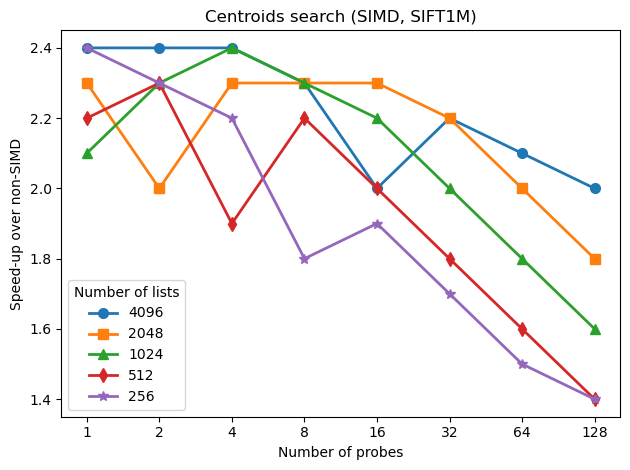

In [36]:
plot(df=centroids_simd_df, y_col='mean_speedup', title='Centroids search (SIMD, SIFT1M)', ylabel='Speed-up over non-SIMD')

Average speedup of `preassign_query()` with SIMD over the execution time without SIMD.

In [37]:
speedup = centroids_simd_df['mean_speedup'].mean()
print(f'Average SIMD speed-up for preassign_query(): {speedup:.1f}x')

Average SIMD speed-up for preassign_query(): 2.1x


## `search_preassigned()`: Execution time

Executing the benchmark with the following command:

```bash
./out/testmain [StorageIndex][search_preassigned][benchmark] --benchmark-samples 3 -r xml >> search_preassigned_simd.xml
```

produces an xml file containing the measurements of the execution time of `search_preassigned` for different values of `n_probe` and `n_lists`.

Reading the measurements from the xml file

In [38]:
results_search_simd = parse_xml('search_preassigned_simd.xml')
search_simd_to_correct_df = results_to_df(results_search_simd)
add_space_estimates(search_simd_to_correct_df)
search_simd_to_correct_df

,n_lists,n_probe,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb
0,256,1,0.001089,6.993900e-06,3906.250000,1.9,0.1
1,256,2,0.002088,2.895100e-06,7812.500000,3.8,0.1
2,256,4,0.003699,5.176340e-07,15625.000000,7.6,0.1
3,256,8,0.007036,2.666590e-06,31250.000000,15.3,0.1
4,256,16,0.013798,5.042440e-06,62500.000000,30.5,0.1
5,256,32,0.027081,1.758560e-05,125000.000000,61.0,0.1
6,256,64,0.053990,1.974420e-06,250000.000000,122.1,0.1
7,256,128,0.106038,2.793850e-06,500000.000000,244.1,0.1
8,512,1,0.000588,8.934170e-06,1953.125000,1.0,0.2
9,512,2,0.001044,9.596510e-06,3906.250000,1.9,0.2


Correcting the estimated execution time of `search_preassigned`

In [39]:
search_simd_df = get_corrected_search_df(search_simd_to_correct_df, centroids_simd_df)
search_simd_df

,n_lists,n_probe,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb
0,256,1,0.001032,9.890868e-06,3906.250000,1.9,0.1
1,256,2,0.002029,4.094290e-06,7812.500000,3.8,0.1
2,256,4,0.003635,7.320450e-07,15625.000000,7.6,0.1
3,256,8,0.006952,3.771128e-06,31250.000000,15.3,0.1
4,256,16,0.013709,7.131087e-06,62500.000000,30.5,0.1
5,256,32,0.026962,2.486979e-05,125000.000000,61.0,0.1
6,256,64,0.053828,2.792252e-06,250000.000000,122.1,0.1
7,256,128,0.105818,3.951101e-06,500000.000000,244.1,0.1
8,512,1,0.000463,1.263482e-05,1953.125000,1.0,0.2
9,512,2,0.000926,1.357151e-05,3906.250000,1.9,0.2


## Plotting the execution time of `search_preassigned()` with SIMD

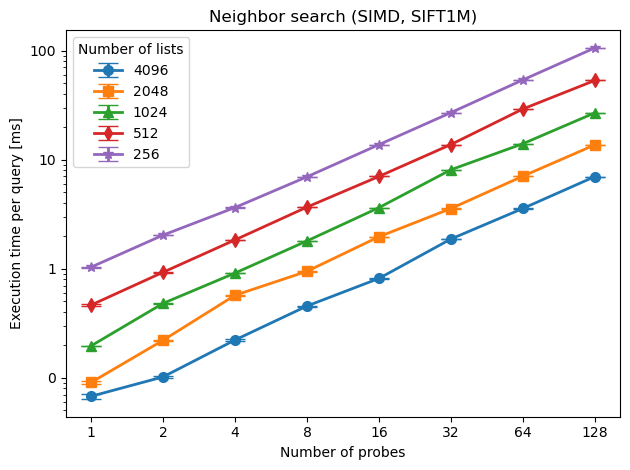

In [40]:
# s_to_ms_formatter = ticker.FuncFormatter(lambda x, pos: '{:0.0f}'.format(x*1000))

plot(df=search_simd_df, y_col='mean', yerr_col='std', title='Neighbor search (SIMD, SIFT1M)', ylabel='Execution time per query [ms]', yaxis_log=True, yformatter=s_to_ms_formatter)

In [41]:
add_search_throughput(search_simd_df)
search_simd_df

,n_lists,n_probe,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,n_vectors_per_s,mb_per_s
0,256,1,0.001032,9.890868e-06,3906.250000,1.9,0.1,3784981.5,1848.1
1,256,2,0.002029,4.094290e-06,7812.500000,3.8,0.1,3851086.1,1880.4
2,256,4,0.003635,7.320450e-07,15625.000000,7.6,0.1,4298488.6,2098.9
3,256,8,0.006952,3.771128e-06,31250.000000,15.3,0.1,4494811.4,2194.7
4,256,16,0.013709,7.131087e-06,62500.000000,30.5,0.1,4559085.5,2226.1
5,256,32,0.026962,2.486979e-05,125000.000000,61.0,0.1,4636228.4,2263.8
6,256,64,0.053828,2.792252e-06,250000.000000,122.1,0.1,4644457.5,2267.8
7,256,128,0.105818,3.951101e-06,500000.000000,244.1,0.1,4725093.1,2307.2
8,512,1,0.000463,1.263482e-05,1953.125000,1.0,0.2,4215944.9,2058.6
9,512,2,0.000926,1.357151e-05,3906.250000,1.9,0.2,4218348.8,2059.7


Plotting the throughput of `search_preassigned()` with SIMD

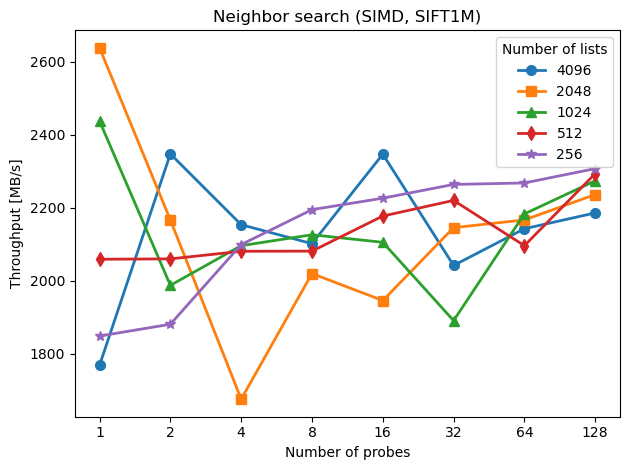

In [42]:
plot(df=search_simd_df, y_col='mb_per_s', title='Neighbor search (SIMD, SIFT1M)', ylabel='Throughput [MB/s]')

Computing the SIMD speedup of `search_preassigned()`

In [43]:
search_simd_df['mean_speedup'] = get_speedup(old_df=search_df, new_df=search_simd_df, column='mean', invert=True)
search_simd_df

,n_lists,n_probe,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,n_vectors_per_s,mb_per_s,mean_speedup
0,256,1,0.001032,9.890868e-06,3906.250000,1.9,0.1,3784981.5,1848.1,2.1
1,256,2,0.002029,4.094290e-06,7812.500000,3.8,0.1,3851086.1,1880.4,2.1
2,256,4,0.003635,7.320450e-07,15625.000000,7.6,0.1,4298488.6,2098.9,2.4
3,256,8,0.006952,3.771128e-06,31250.000000,15.3,0.1,4494811.4,2194.7,2.4
4,256,16,0.013709,7.131087e-06,62500.000000,30.5,0.1,4559085.5,2226.1,2.4
5,256,32,0.026962,2.486979e-05,125000.000000,61.0,0.1,4636228.4,2263.8,2.4
6,256,64,0.053828,2.792252e-06,250000.000000,122.1,0.1,4644457.5,2267.8,2.4
7,256,128,0.105818,3.951101e-06,500000.000000,244.1,0.1,4725093.1,2307.2,2.4
8,512,1,0.000463,1.263482e-05,1953.125000,1.0,0.2,4215944.9,2058.6,2.5
9,512,2,0.000926,1.357151e-05,3906.250000,1.9,0.2,4218348.8,2059.7,2.4


In [44]:
speedup = search_simd_df['mean_speedup'].mean()
print(f'Average SIMD speed-up for search_preassigned(): {speedup:.1f}x')


Average SIMD speed-up for search_preassigned(): 2.4x


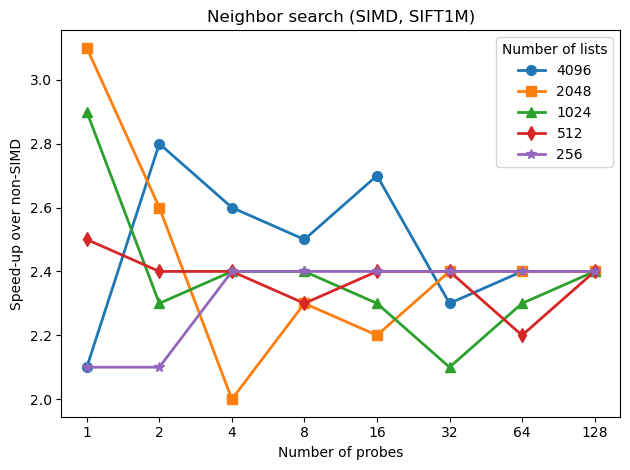

In [45]:
plot(df=search_simd_df, y_col='mean_speedup', title='Neighbor search (SIMD, SIFT1M)', ylabel='Speed-up over non-SIMD')

# Parallelization using OpenMP (SIMD enabled)

- The following benchmarks were executed on a `Intel Xeon E5-2640 @ 2.4 GHz` with 32 cores, each with 2 threads.
- OpenMP was configured to use as many threads as it deemed necessary by setting `OMP_NUM_THREADS` to `64`, an environment variable which sets the maximum thread count.

## `preassign_query()`: Execution time

The benchmarks were executed with the following command the benchmark by running the following command:
```bash
export OMP_NUM_THREADS=64; ./out/testmain [StorageIndex][preassign_query][SIFT1M][benchmark] --benchmark-samples 3 -r xml >> preassign_query_simd_omp.xml

Reading from the xml file

In [46]:
results_simd_omp = parse_xml('preassign_query_simd_omp.xml')
centroids_simd_omp_df = results_to_df(results_simd_omp)
add_space_estimates(centroids_simd_omp_df)
centroids_simd_omp_df

,n_lists,n_probe,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb
0,256,1,0.000004,5.377020e-08,3906.250000,1.9,0.1
1,256,2,0.000004,3.194630e-07,7812.500000,3.8,0.1
2,256,4,0.000004,6.304420e-08,15625.000000,7.6,0.1
3,256,8,0.000004,1.439830e-07,31250.000000,15.3,0.1
4,256,16,0.000004,1.070190e-07,62500.000000,30.5,0.1
5,256,32,0.000005,1.615560e-07,125000.000000,61.0,0.1
6,256,64,0.000006,8.034850e-08,250000.000000,122.1,0.1
7,256,128,0.000008,1.383600e-07,500000.000000,244.1,0.1
8,512,1,0.000007,2.170580e-07,1953.125000,1.0,0.2
9,512,2,0.000007,2.401230e-07,3906.250000,1.9,0.2


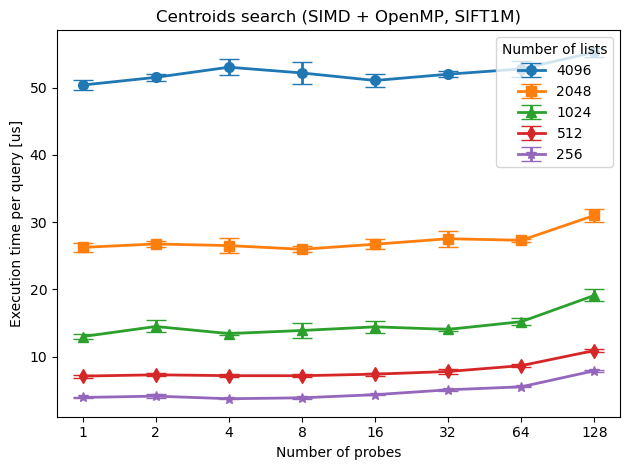

In [47]:
s_to_us_formatter = ticker.FuncFormatter(lambda x, pos: '{:0.0f}'.format(x*1e6))
plot(df=centroids_simd_omp_df, y_col='mean', yerr_col='std', title='Centroids search (SIMD + OpenMP, SIFT1M)', ylabel='Execution time per query [us]', yformatter=s_to_us_formatter)

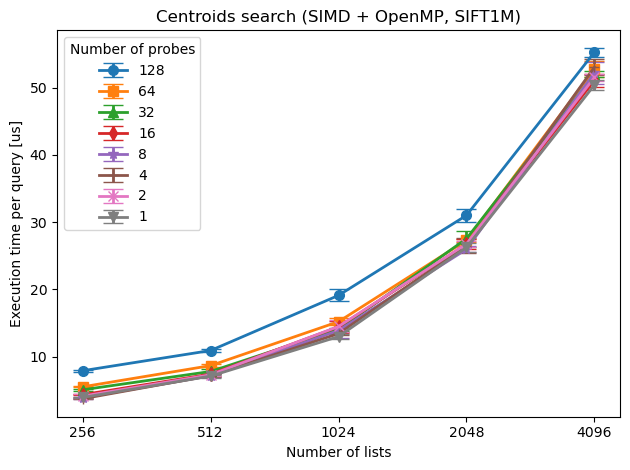

In [48]:
plot(df=centroids_simd_omp_df, y_col='mean', yerr_col='std', title='Centroids search (SIMD + OpenMP, SIFT1M)', ylabel='Execution time per query [us]', yformatter=s_to_us_formatter, plot_over_lists=True)

Computing the throughput of `preassign_query()` with SIMD and OpenMP

In [49]:
add_centroids_search_throughput(centroids_simd_omp_df)
centroids_simd_df

,n_lists,n_probe,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,vectors_per_s,mb_per_s,mean_speedup
0,256,1,0.000057,2.865240e-07,3906.250000,1.9,0.1,4491180.8,2193.0,2.4
1,256,2,0.000059,2.583800e-08,7812.500000,3.8,0.1,4322754.4,2110.7,2.3
2,256,4,0.000064,1.505830e-07,15625.000000,7.6,0.1,3983729.0,1945.2,2.2
3,256,8,0.000083,1.100390e-07,31250.000000,15.3,0.1,3066999.6,1497.6,1.8
4,256,16,0.000089,1.110600e-07,62500.000000,30.5,0.1,2869620.6,1401.2,1.9
5,256,32,0.000120,9.869250e-08,125000.000000,61.0,0.1,2136377.7,1043.2,1.7
6,256,64,0.000163,1.611240e-07,250000.000000,122.1,0.1,1573448.1,768.3,1.5
7,256,128,0.000220,1.681180e-07,500000.000000,244.1,0.1,1163747.4,568.2,1.4
8,512,1,0.000125,1.137170e-07,1953.125000,1.0,0.2,4104142.6,2004.0,2.2
9,512,2,0.000117,1.227280e-07,3906.250000,1.9,0.2,4357966.1,2127.9,2.3


Plotting the throughput of `preassign_query()` with SIMD and OpenMP

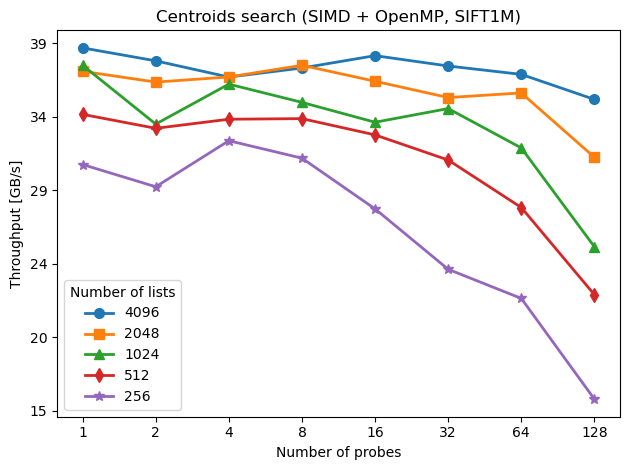

In [50]:
mb_to_gb_formatter = ticker.FuncFormatter(lambda x, pos: '{:0.0f}'.format(x/2**10))
plot(df=centroids_simd_omp_df, y_col='mb_per_s', title='Centroids search (SIMD + OpenMP, SIFT1M)', ylabel='Throughput [GB/s]', yformatter=mb_to_gb_formatter)

Computing SIMD + OpenMP speedup of `preassign_query()`

In [51]:
centroids_simd_omp_df['mean_speedup'] = get_speedup(old_df=centroids_df, new_df=centroids_simd_omp_df, column='mean', invert=True)
centroids_simd_omp_df

,n_lists,n_probe,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,vectors_per_s,mb_per_s,mean_speedup
0,256,1,0.000004,5.377020e-08,3906.250000,1.9,0.1,65035528.2,31755.6,34.6
1,256,2,0.000004,3.194630e-07,7812.500000,3.8,0.1,61943326.7,30245.8,33.5
2,256,4,0.000004,6.304420e-08,15625.000000,7.6,0.1,68350510.0,33374.3,38.2
3,256,8,0.000004,1.439830e-07,31250.000000,15.3,0.1,65921784.8,32188.4,39.6
4,256,16,0.000004,1.070190e-07,62500.000000,30.5,0.1,58859911.1,28740.2,38.7
5,256,32,0.000005,1.615560e-07,125000.000000,61.0,0.1,50446431.2,24632.0,39.0
6,256,64,0.000006,8.034850e-08,250000.000000,122.1,0.1,46393873.1,22653.3,43.9
7,256,128,0.000008,1.383600e-07,500000.000000,244.1,0.1,32365528.2,15803.5,38.0
8,512,1,0.000007,2.170580e-07,1953.125000,1.0,0.2,72023205.0,35167.6,37.9
9,512,2,0.000007,2.401230e-07,3906.250000,1.9,0.2,70078619.5,34218.1,37.3


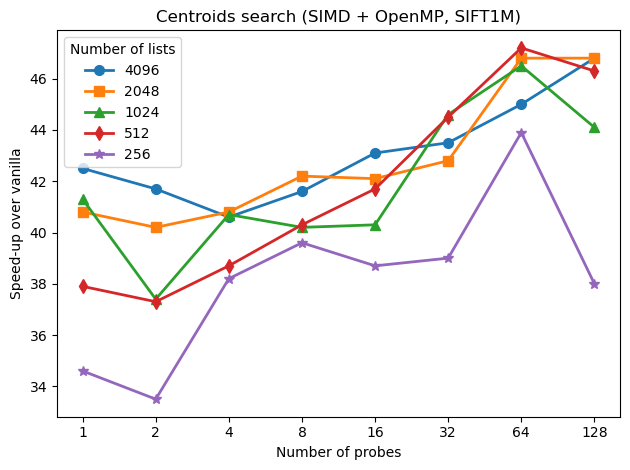

In [52]:
speedup_formatter = ticker.FuncFormatter(lambda x, pos: '{:0.0f}'.format(x))
plot(df=centroids_simd_omp_df, y_col='mean_speedup', title='Centroids search (SIMD + OpenMP, SIFT1M)', ylabel='Speed-up over vanilla', yformatter=speedup_formatter)

Average speedup of `preassign_query()` with SIMD and OpenMP over the execution time without SIMD and OpenMP.

In [53]:
speedup = centroids_simd_omp_df['mean_speedup'].mean()
print(f'Average SIMD + OpenMP speed-up for preassign_query(): {speedup:.1f}x')

Average SIMD + OpenMP speed-up for preassign_query(): 41.5x


## `search_preassigned()`: Execution time
The benchmarks were executed with the following command:
```bash
export OMP_NUM_THREADS=64; ./out/testmain [StorageIndex][search_preassigned][SIFT1M][benchmark] --benchmark-samples 3 -r xml >> search_preassigned_simd_omp.xml
```

Reading the measurements from the xml file

In [54]:
results_simd_omp = parse_xml('search_preassigned_simd_omp.xml')
search_simd_omp_df = results_to_df(results_simd_omp)
add_space_estimates(search_simd_omp_df)
search_simd_omp_df

,n_lists,n_probe,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb
0,256,1,0.000089,5.021210e-06,3906.250000,1.9,0.1
1,256,2,0.000144,5.188510e-07,7812.500000,3.8,0.1
2,256,4,0.000225,7.528370e-07,15625.000000,7.6,0.1
3,256,8,0.000442,3.569200e-07,31250.000000,15.3,0.1
4,256,16,0.000951,1.676090e-05,62500.000000,30.5,0.1
5,256,32,0.001930,7.768390e-05,125000.000000,61.0,0.1
6,256,64,0.004433,2.109410e-04,250000.000000,122.1,0.1
7,256,128,0.008397,1.396130e-04,500000.000000,244.1,0.1
8,512,1,0.000048,7.215030e-08,1953.125000,1.0,0.2
9,512,2,0.000072,1.516320e-06,3906.250000,1.9,0.2


## Plotting the execution time of `search_preassigned()` with SIMD and OpenMP

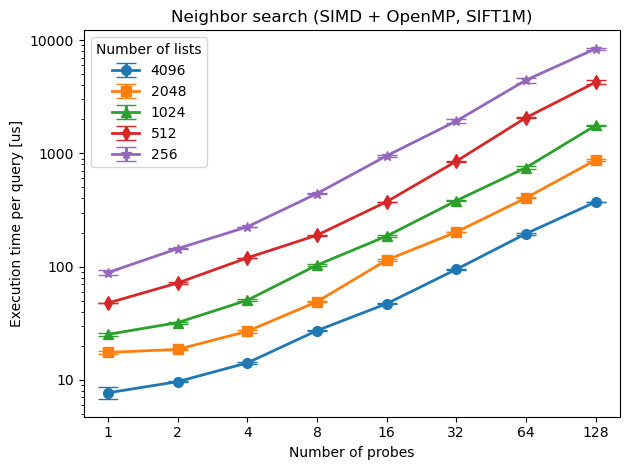

In [55]:
plot(df=search_simd_omp_df, y_col='mean', yerr_col='std', title='Neighbor search (SIMD + OpenMP, SIFT1M)', ylabel='Execution time per query [us]', yformatter=s_to_us_formatter, yaxis_log=True)

Computing the throughput of `search_preassigned()` with SIMD and OpenMP (both with and without the correction)

In [56]:
add_search_throughput(search_simd_omp_df)
search_simd_omp_df

,n_lists,n_probe,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,n_vectors_per_s,mb_per_s
0,256,1,0.000089,5.021210e-06,3906.250000,1.9,0.1,44048181.5,21507.9
1,256,2,0.000144,5.188510e-07,7812.500000,3.8,0.1,54193257.5,26461.6
2,256,4,0.000225,7.528370e-07,15625.000000,7.6,0.1,69567811.4,33968.7
3,256,8,0.000442,3.569200e-07,31250.000000,15.3,0.1,70721677.9,34532.1
4,256,16,0.000951,1.676090e-05,62500.000000,30.5,0.1,65705025.4,32082.5
5,256,32,0.001930,7.768390e-05,125000.000000,61.0,0.1,64781944.0,31631.8
6,256,64,0.004433,2.109410e-04,250000.000000,122.1,0.1,56396617.1,27537.4
7,256,128,0.008397,1.396130e-04,500000.000000,244.1,0.1,59542664.7,29073.6
8,512,1,0.000048,7.215030e-08,1953.125000,1.0,0.2,40964910.4,20002.4
9,512,2,0.000072,1.516320e-06,3906.250000,1.9,0.2,54474016.3,26598.6


Plotting the throughput of `search_preassigned()` with SIMD and OpenMP

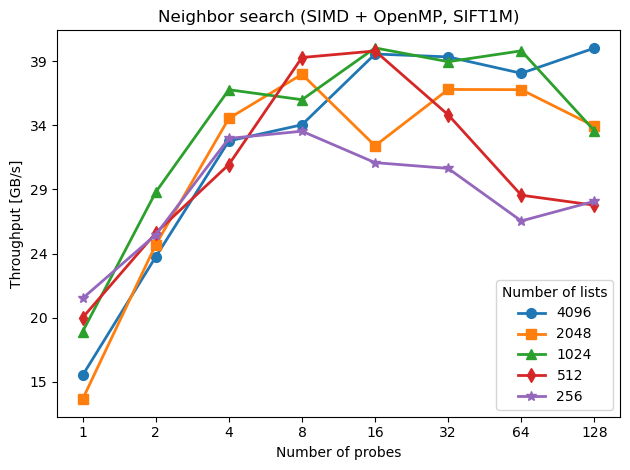

In [57]:
plot(df=search_simd_omp_df, y_col='mb_per_s', title='Neighbor search (SIMD + OpenMP, SIFT1M)', ylabel='Throughput [GB/s]', yformatter=mb_to_gb_formatter)

Computing the speedup of `search_preassigned()` with SIMD and OpenMP over the execution time without SIMD and OpenMP

In [58]:
search_simd_omp_df['mean_speedup'] = get_speedup(old_df=search_df, new_df=search_simd_omp_df, column='mean', invert=True)
search_simd_omp_df

,n_lists,n_probe,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,n_vectors_per_s,mb_per_s,mean_speedup
0,256,1,0.000089,5.021210e-06,3906.250000,1.9,0.1,44048181.5,21507.9,24.9
1,256,2,0.000144,5.188510e-07,7812.500000,3.8,0.1,54193257.5,26461.6,30.2
2,256,4,0.000225,7.528370e-07,15625.000000,7.6,0.1,69567811.4,33968.7,38.1
3,256,8,0.000442,3.569200e-07,31250.000000,15.3,0.1,70721677.9,34532.1,38.1
4,256,16,0.000951,1.676090e-05,62500.000000,30.5,0.1,65705025.4,32082.5,34.8
5,256,32,0.001930,7.768390e-05,125000.000000,61.0,0.1,64781944.0,31631.8,33.8
6,256,64,0.004433,2.109410e-04,250000.000000,122.1,0.1,56396617.1,27537.4,29.0
7,256,128,0.008397,1.396130e-04,500000.000000,244.1,0.1,59542664.7,29073.6,30.4
8,512,1,0.000048,7.215030e-08,1953.125000,1.0,0.2,40964910.4,20002.4,24.0
9,512,2,0.000072,1.516320e-06,3906.250000,1.9,0.2,54474016.3,26598.6,31.1


In [59]:
speedup = search_simd_omp_df['mean_speedup'].mean()
print(f'Average SIMD + OpenMP speed-up over vanilla search for search_preassigned(): {speedup:.1f}x')

Average SIMD + OpenMP speed-up over vanilla search for search_preassigned(): 36.4x


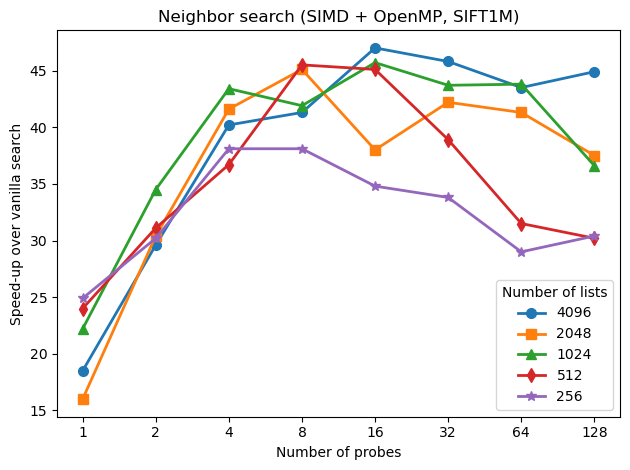

In [60]:
plot(df=search_simd_omp_df, y_col='mean_speedup', title='Neighbor search (SIMD + OpenMP, SIFT1M)', ylabel='Speed-up over vanilla search')

# Parallelization over both queries and lists using OpenMP (SIMD enabled)

## `search_preassigned()`: Execution time

The project was compiled to parallelization over both queries and lists using the following command:
```bash
make test PMODE=2
```


The benchmarks were executed by running the following command:
```bash
export OMP_NUM_THREADS=64; ./out/testmain [StorageIndex][search_preassigned][SIFT1M][benchmark] --benchmark-samples 3 -r xml >> search_preassigned_simd_omp_pmode2.xml
```

In [74]:
results_simd_omp_pmode2 = parse_xml('search_preassigned_simd_omp_pmode2.xml')
search_simd_omp_pmode2_df = results_to_df(results_simd_omp_pmode2)
add_space_estimates(search_simd_omp_pmode2_df)
add_search_throughput(search_simd_omp_pmode2_df)
search_simd_omp_pmode2_df

,n_lists,n_probe,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,n_vectors_per_s,mb_per_s
0,256,1,0.000088,1.028950e-06,3906.250000,1.9,0.1,44275095.5,21618.7
1,256,2,0.000171,2.364040e-06,7812.500000,3.8,0.1,45655896.3,22292.9
2,256,4,0.000338,4.320410e-06,15625.000000,7.6,0.1,46167028.6,22542.5
3,256,8,0.000543,3.847380e-06,31250.000000,15.3,0.1,57557216.5,28104.1
4,256,16,0.001067,1.057010e-05,62500.000000,30.5,0.1,58556786.0,28592.2
5,256,32,0.002289,5.186840e-06,125000.000000,61.0,0.1,54600889.3,26660.6
6,256,64,0.004104,9.311060e-05,250000.000000,122.1,0.1,60917812.1,29745.0
7,256,128,0.008209,2.575860e-04,500000.000000,244.1,0.1,60912320.4,29742.3
8,512,1,0.000052,9.901940e-07,1953.125000,1.0,0.2,37753364.3,18434.3
9,512,2,0.000093,1.666660e-06,3906.250000,1.9,0.2,41873690.2,20446.1


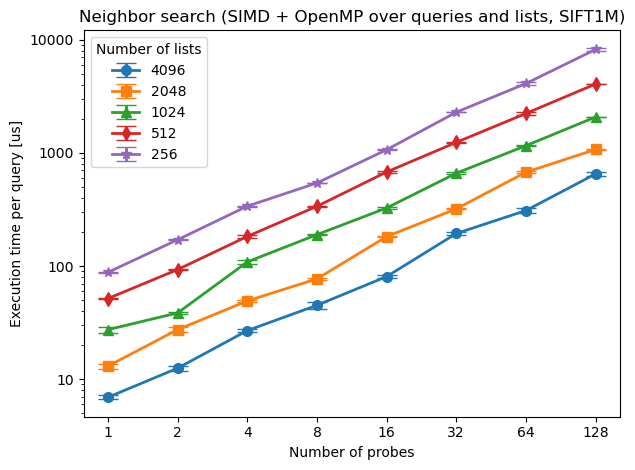

In [75]:
plot(df=search_simd_omp_pmode2_df, y_col='mean', yerr_col='std', title='Neighbor search (SIMD + OpenMP over queries and lists, SIFT1M)', ylabel='Execution time per query [us]', yformatter=s_to_us_formatter, yaxis_log=True)

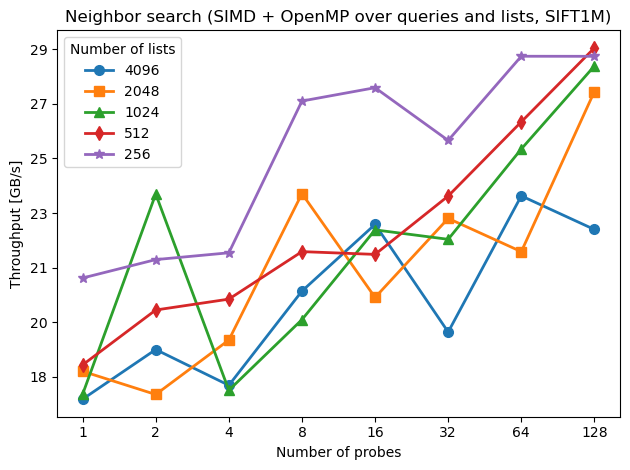

In [76]:
plot(df=search_simd_omp_pmode2_df, y_col='mb_per_s', title='Neighbor search (SIMD + OpenMP over queries and lists, SIFT1M)', ylabel='Throughput [GB/s]', yformatter=mb_to_gb_formatter)

In [80]:
search_simd_omp_pmode2_df['mean_speedup'] = get_speedup(old_df=search_simd_omp_df, new_df=search_simd_omp_pmode2_df, column='mean', invert=True)
search_simd_omp_pmode2_df

,n_lists,n_probe,mean,std,n_vectors_to_search,search_space_size_mb,centroids_total_size_mb,n_vectors_per_s,mb_per_s,mean_speedup
0,256,1,0.000088,1.028950e-06,3906.250000,1.9,0.1,44275095.5,21618.7,1.0
1,256,2,0.000171,2.364040e-06,7812.500000,3.8,0.1,45655896.3,22292.9,0.8
2,256,4,0.000338,4.320410e-06,15625.000000,7.6,0.1,46167028.6,22542.5,0.7
3,256,8,0.000543,3.847380e-06,31250.000000,15.3,0.1,57557216.5,28104.1,0.8
4,256,16,0.001067,1.057010e-05,62500.000000,30.5,0.1,58556786.0,28592.2,0.9
5,256,32,0.002289,5.186840e-06,125000.000000,61.0,0.1,54600889.3,26660.6,0.8
6,256,64,0.004104,9.311060e-05,250000.000000,122.1,0.1,60917812.1,29745.0,1.1
7,256,128,0.008209,2.575860e-04,500000.000000,244.1,0.1,60912320.4,29742.3,1.0
8,512,1,0.000052,9.901940e-07,1953.125000,1.0,0.2,37753364.3,18434.3,0.9
9,512,2,0.000093,1.666660e-06,3906.250000,1.9,0.2,41873690.2,20446.1,0.8


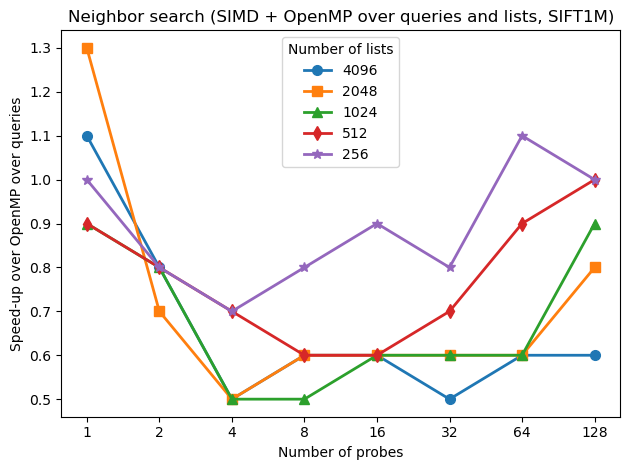

In [85]:
plot(df=search_simd_omp_pmode2_df, y_col='mean_speedup', title='Neighbor search (SIMD + OpenMP over queries and lists, SIFT1M)', ylabel='Speed-up over OpenMP over queries')